In [90]:
import pandas as pd
import bz2


dataset = pd.read_csv("train_data_percentage", index_col=0)
dataset = dataset.dropna()
dataset = (dataset[(dataset.lang=="en")]).reset_index(drop=True).sort_index()
dataset = dataset.reset_index(drop=True).sort_index()


In [91]:
# Create categories from priceChanges
stepKey = "1stepChange"
threshold = 0.005
dataset.insert(loc=9,column="priceChangeClass", value=1)
dataset.at[dataset[dataset[stepKey] <= (1-threshold)].index, "priceChangeClass"] = 0
dataset.at[dataset[dataset[stepKey] >= (1+threshold)].index, "priceChangeClass"] = 2

In [92]:
smallest_amount_data = min(dataset.priceChangeClass.value_counts())

indexes = []
for unique_class in set(dataset.priceChangeClass):
        temp_indexes = dataset.loc[dataset.priceChangeClass==unique_class].sample(smallest_amount_data).index
        #print(list(temp_indexes))
        indexes += list(temp_indexes)

In [108]:
# Pick out indexes, shuffle rows, and reset indexes
balanced_dataset = dataset.loc[indexes].sample(frac=1).reset_index(drop=True)
balanced_dataset.iloc[195698].summary

"NEW YORK , Sept. 16, 2020 /PRNewswire/ -- Significant rise in demand for hygiene products such as tampons and pads is due to increased awareness about feminine hygiene and their importance for women health. In developing and under-developed countries, the penetration of tampons is slightly low and they are not easily available. Reason being, lack of feminine hygiene awareness among people, which is one of the factors hampering the growth of the tampon market to some extent. But the tampon market is still in the growth stage, and is expected to surge over the coming decade. According to PMR's report, the tampon market is estimated to register a CAGR of 6% during the forecast period of 2020-2030, to reach a valuation of around US$ 7.4 Bn by the end of 2030. Key Takeaways from Global Tampon Market Study According to the report, the global tampon market represents a fairly consolidated competition landscape, where a majority of key players maintain strategic focus on new product developme

In [94]:
seed = 12345

val_percent = 0.1
test_percent = 0.2

validation_data = (balanced_dataset.sample(frac=val_percent, random_state=seed)).reset_index(drop=True)
test_data = (balanced_dataset.sample(frac=test_percent, random_state=seed)).reset_index(drop=True)
train_data = (balanced_dataset.iloc[balanced_dataset.index.difference(test_data.index).difference(validation_data.index)]).reset_index(drop=True)

In [95]:
train_data['priceChangeClass'].value_counts()

2    52223
1    52194
0    52142
Name: priceChangeClass, dtype: int64

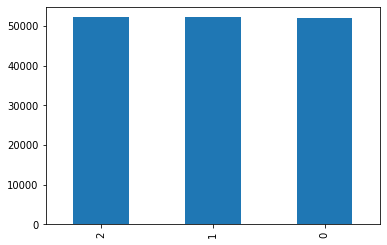

In [96]:
import matplotlib.pyplot as plt
train_data['priceChangeClass'].value_counts().plot(kind='bar');

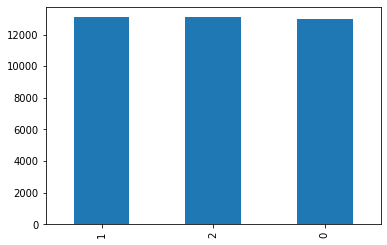

In [97]:
test_data['priceChangeClass'].value_counts().plot(kind='bar');

## Naive Bayes classifier¶

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [99]:
steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)

Pipeline(steps=[('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())])

In [100]:
pipeline.score(test_data.summary, test_data.priceChangeClass)

0.5188042922841083

In [101]:
steps= [('vec', TfidfVectorizer()), ('multinomialnb', MultinomialNB())]
pipeline2 = Pipeline(steps)
pipeline2.fit(train_data.summary, train_data.priceChangeClass)

Pipeline(steps=[('vec', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])

In [102]:
pipeline2.score(test_data.summary, test_data.priceChangeClass)

0.5314767501277465

(array([12091.,     0.,     0.,     0.,     0., 15572.,     0.,     0.,
            0., 11477.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

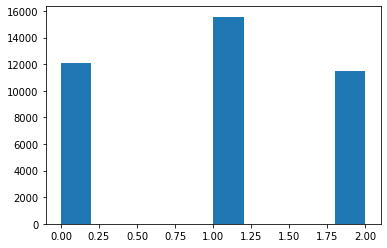

In [79]:
predicted = pipeline.predict(test_data.summary)
plt.hist(predicted)

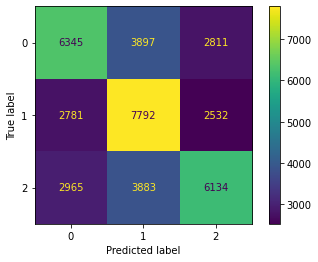

In [80]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)


## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train_data.summary, train_data.priceChangeClass)
dummy_clf.score(test_data.summary, test_data.priceChangeClass)

0.33206438426162493

An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [18]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_data.summary, train_data.priceChangeClass)
dummy_clf.score(test_data.summary, test_data.priceChangeClass)



0.33114460909555443

## Problem 4: Creating a balanced data set

## Problem 5: Confusion matrix

In [19]:
from sklearn.model_selection import GridSearchCV

steps= [('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())]
new_pipeline = Pipeline(steps)
#a = GridSearchCV(estimator=new_pipeline, param_grid={"vec__binary": [True, False],"vec__ngram_range":[(1,1), (1,2)], 
#                                                     "multinomialnb__alpha":[1,0.1]})
new_pipeline.fit(train_data.summary, train_data.priceChangeClass)


Pipeline(steps=[('vec', CountVectorizer()), ('multinomialnb', MultinomialNB())])

In [20]:
#print(a.best_params_)
new_pipeline.score(test_data.summary,test_data.priceChangeClass)

0.5202861522738886

## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model. Did you manage to get better results than the ones that you obtained in Problem&nbsp;6? Answer with a short text.

In [81]:
from sklearn.svm import SVC

steps = [('vec', CountVectorizer()), ('svc',  SVC())]

#parameters = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

pipeline = Pipeline(steps)

#clf = GridSearchCV(pipeline, parameters)
pipeline.fit(train_data.summary[:5000], train_data.priceChangeClass[:5000])


Pipeline(steps=[('vec', CountVectorizer()), ('svc', SVC())])

In [89]:
#print(pipeline.best_params_)
pipeline.score(test_data.summary,test_data.priceChangeClass)

NotFittedError: Vocabulary not fitted or provided

In [103]:
from sklearn.neural_network import MLPClassifier

steps = [('vec', TfidfVectorizer()), ('net',  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,10), random_state=1,max_iter=3000))]
pipeline = Pipeline(steps)
pipeline.fit(train_data.summary, train_data.priceChangeClass)


/home/hugo/.virtualenvs/stock-news/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('vec', TfidfVectorizer()),
                ('net',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(15, 10),
                               max_iter=3000, random_state=1,
                               solver='lbfgs'))])

In [104]:
pipeline.score(test_data.summary,test_data.priceChangeClass)

0.762008175779254

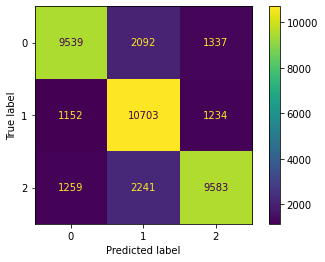

In [105]:
plot_confusion_matrix(pipeline, test_data.summary, test_data.priceChangeClass)

In [106]:
from sklearn.metrics import f1_score,classification_report

res = pipeline.predict(test_data.summary)

print(classification_report(test_data.priceChangeClass, res))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     12968
           1       0.71      0.82      0.76     13089
           2       0.79      0.73      0.76     13083

    accuracy                           0.76     39140
   macro avg       0.77      0.76      0.76     39140
weighted avg       0.77      0.76      0.76     39140

